In [8]:
%load_ext jupyter_black
import branca
import folium
import calendar
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.colors as mcolors
from folium.plugins import MarkerCluster
from plotly.subplots import make_subplots

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [9]:
df_train = pd.read_csv("test_data_scientist/train.csv.gz", compression="gzip")
df_test = pd.read_csv("test_data_scientist/test.csv.gz", compression="gzip")
df_bu_feat = pd.read_csv("test_data_scientist/bu_feat.csv.gz", compression="gzip")

print(df_train.shape)
print(df_train.head())

print(df_test.shape)
print(df_test.head())

print(df_bu_feat.shape)
print(df_bu_feat.head())

(277719, 4)
       day_id  but_num_business_unit  dpt_num_department     turnover
0  2017-09-30                     64                 127   580.308443
1  2017-09-30                    119                 127  1512.995918
2  2017-09-30                      4                  88   668.593556
3  2017-09-30                    425                 127     0.000000
4  2017-09-30                    513                  73     0.000000
(10136, 3)
       day_id  but_num_business_unit  dpt_num_department
0  2017-11-25                     95                  73
1  2017-11-25                      4                 117
2  2017-11-25                    113                 127
3  2017-11-25                     93                 117
4  2017-11-25                     66                 127
(326, 6)
   but_num_business_unit  but_postcode  but_latitude  but_longitude  \
0                   1609         80100     50.096306       1.867220   
1                   1995         95700     48.991087       2.520

In [30]:
def plot_hist(
    df, kind="bar", grid=False, color=None, title="None", xlabel="None", ylabel="None"
):
    plt.figure(figsize=(10, 5))
    df.plot(kind=kind, color=color)
    plt.grid(grid)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [31]:
df_train["day_id"] = pd.to_datetime(df_train["day_id"])
print(df_train.info())
print("=========== Check missing ===========")
print(df_train.isna().sum())
print("=========== Turnover information ===========")
df_train["turnover"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277719 entries, 0 to 277718
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   day_id                 277719 non-null  datetime64[ns]
 1   but_num_business_unit  277719 non-null  int64         
 2   dpt_num_department     277719 non-null  int64         
 3   turnover               277719 non-null  float64       
 4   year                   277719 non-null  int32         
 5   month                  277719 non-null  int32         
 6   month_name             277719 non-null  object        
 7   season                 277719 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2), object(2)
memory usage: 14.8+ MB
None
=========== Check missing ===========
day_id                   0
but_num_business_unit    0
dpt_num_department       0
turnover                 0
year                     0
month               

count     277719.000000
mean         561.818472
std         2113.229765
min          -69.791165
25%           11.785140
50%          232.724186
75%          676.655825
max      1000000.000000
Name: turnover, dtype: float64

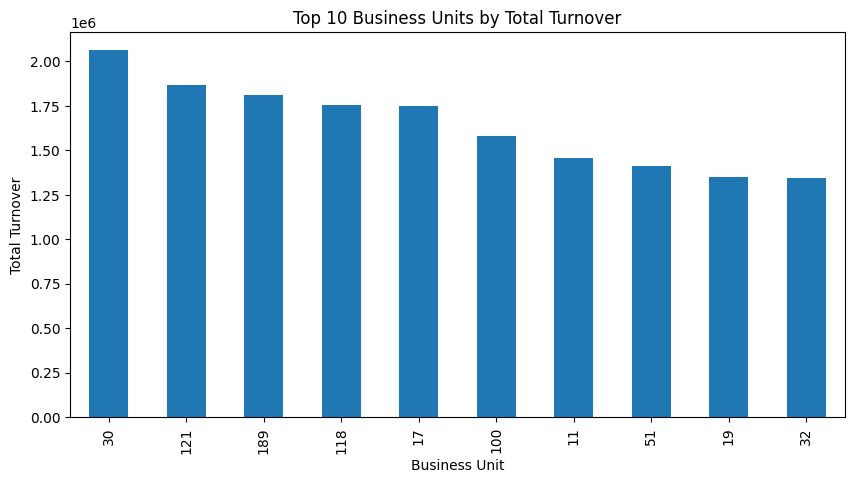

In [33]:
bu_sales = (
    df_train.groupby("but_num_business_unit")["turnover"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plot_hist(
    bu_sales,
    title="Top 10 Business Units by Total Turnover",
    xlabel="Business Unit",
    ylabel="Total Turnover",
)

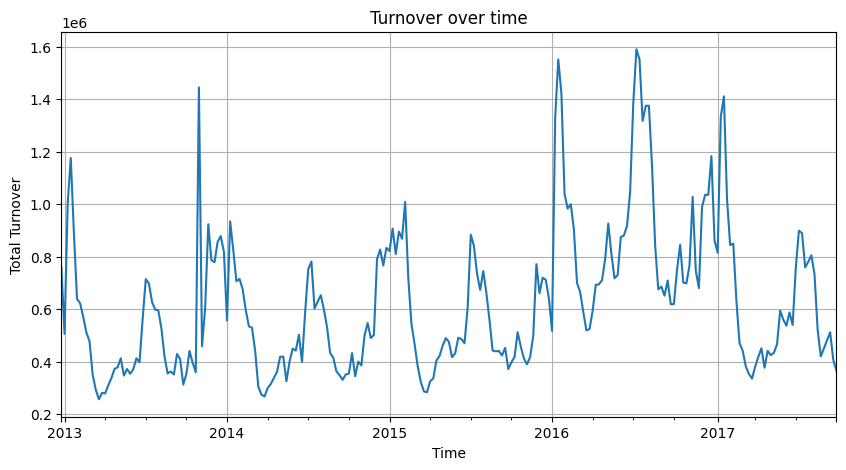

In [39]:
daily_sales = df_train.groupby("day_id")["turnover"].sum()
plot_hist(
    daily_sales,
    title="Turnover over time",
    xlabel="Time",
    ylabel="Total Turnover",
    kind="line",
    grid=True,
)

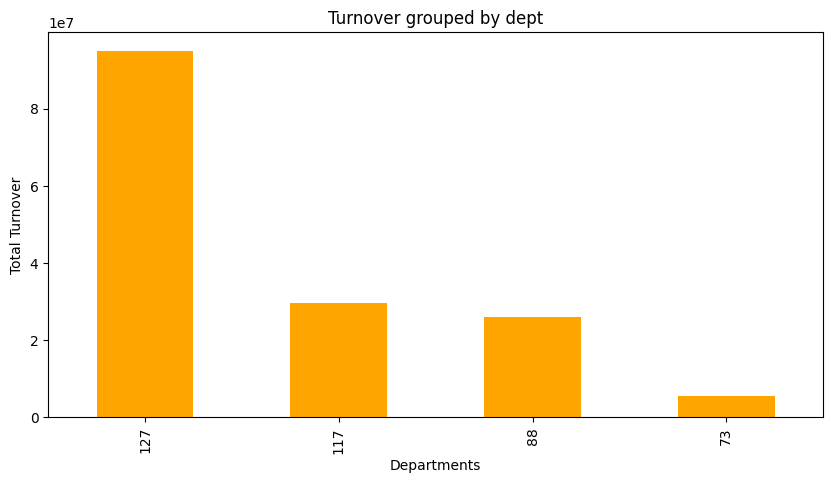

In [37]:
dept_sales = (
    df_train.groupby("dpt_num_department")["turnover"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
plot_hist(
    dept_sales,
    title="Turnover grouped by dept",
    xlabel="Departments",
    ylabel="Total Turnover",
    kind="bar",
    grid=False,
    color="orange",
)

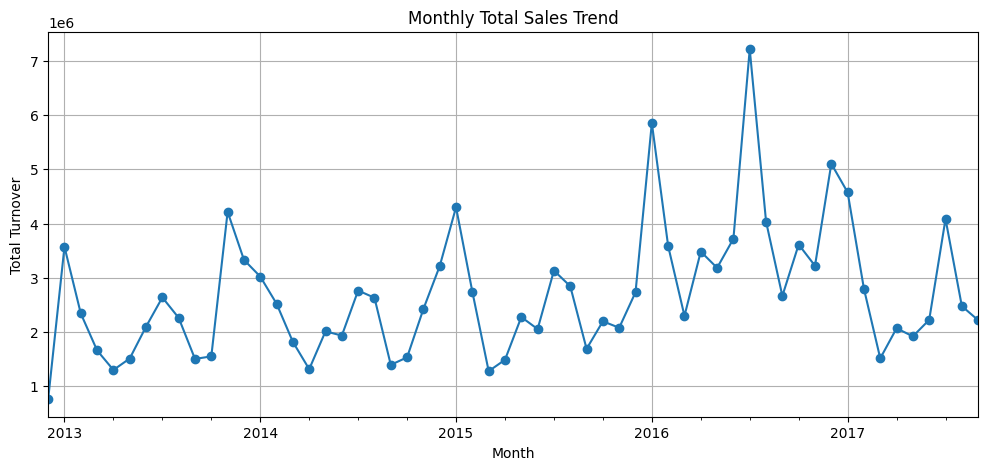

In [15]:
monthly_sales = df_train.groupby(df_train["day_id"].dt.to_period("M"))["turnover"].sum()
plt.figure(figsize=(12, 5))
monthly_sales.plot(marker="o")
plt.title("Monthly Total Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Turnover")
plt.grid(True)
plt.show()

In [16]:
df_merged = df_train.merge(
    df_bu_feat,
    on="but_num_business_unit",
    how="left",
)

print(df_merged.shape)
print(df_merged.head())

(277719, 9)
      day_id  but_num_business_unit  dpt_num_department     turnover  \
0 2017-09-30                     64                 127   580.308443   
1 2017-09-30                    119                 127  1512.995918   
2 2017-09-30                      4                  88   668.593556   
3 2017-09-30                    425                 127     0.000000   
4 2017-09-30                    513                  73     0.000000   

   but_postcode  but_latitude  but_longitude  but_region_idr_region  \
0         16400     45.625172       0.111939                     70   
1         74100     46.195037       6.254448                     51   
2          6600     43.600994       7.078160                     55   
3         59000     50.617921       3.084186                     33   
4         33610     44.717366      -0.733429                     33   

   zod_idr_zone_dgr  
0                10  
1                 4  
2                10  
3                 3  
4                 

In [17]:
store_sales_grouped = (
    df_merged.groupby(["but_num_business_unit", "but_latitude", "but_longitude"])[
        "turnover"
    ]
    .sum()
    .reset_index()
)


store_sales_grouped["turnover_log"] = np.log1p(store_sales_grouped["turnover"])


turnover_min = store_sales_grouped["turnover_log"].min()
turnover_max = store_sales_grouped["turnover_log"].max()


cmap = cm.get_cmap("viridis")

m = folium.Map(
    location=[
        store_sales_grouped["but_latitude"].mean(),
        store_sales_grouped["but_longitude"].mean(),
    ],
    zoom_start=6,
)

marker_cluster = MarkerCluster().add_to(m)


min_radius = 3
max_radius = 15


for _, row in store_sales_grouped.iterrows():

    norm_val = (row["turnover_log"] - turnover_min) / (turnover_max - turnover_min)
    color = mcolors.to_hex(cmap(norm_val))

    radius = min_radius + (max_radius - min_radius) * norm_val

    folium.CircleMarker(
        location=[row["but_latitude"], row["but_longitude"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"BU: {row['but_num_business_unit']}<br>"
        f"Total Turnover: {row['turnover']:.2f}",
    ).add_to(marker_cluster)


colormap = branca.colormap.LinearColormap(
    ["#440154", "#fde725"],
    vmin=turnover_min,
    vmax=turnover_max,
    caption="Log(Turnover + 1)",
)
colormap.add_to(m)

m

/tmp/ipykernel_296542/2796280408.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


## Adding support table

In [18]:
postcode_sales = (
    df_merged.groupby("but_postcode")["turnover"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print(postcode_sales)

but_postcode
38700    2.061849e+06
69500    1.926577e+06
75000    1.811004e+06
59650    1.757522e+06
34000    1.747828e+06
44800    1.581692e+06
95222    1.454358e+06
74330    1.412699e+06
84130    1.350002e+06
29490    1.343822e+06
Name: turnover, dtype: float64


## Analyzing Departments 73 and 117

In [19]:
df_train["day_id"] = pd.to_datetime(df_train["day_id"])
monthly_sales_dept = (
    df_train.groupby([df_train["day_id"].dt.to_period("M"), "dpt_num_department"])[
        "turnover"
    ]
    .sum()
    .unstack(fill_value=0)
)


monthly_sales_dept = monthly_sales_dept.reset_index()
monthly_sales_dept["day_id"] = monthly_sales_dept["day_id"].dt.to_timestamp()


monthly_sales_long = monthly_sales_dept.melt(
    id_vars="day_id", var_name="Department", value_name="Turnover"
)


fig = px.line(
    monthly_sales_long,
    x="day_id",
    y="Turnover",
    color="Department",
    markers=True,
    title="Monthly Total Sales Trend by Department",
)


fig.update_xaxes(
    tickformat="%b %Y",
    dtick="M1",
    tickangle=45,
    showgrid=True,
    gridcolor="lightgrey",
)
fig.update_yaxes(showgrid=True, gridcolor="lightgrey")

fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Total Turnover",
    legend_title="Department",
    template="plotly_white",
)

fig.show()

In [20]:
df_train["day_id"] = pd.to_datetime(df_train["day_id"])
df_train["year"] = df_train["day_id"].dt.year
df_train["month"] = df_train["day_id"].dt.month
df_train["month_name"] = df_train["day_id"].dt.strftime("%b")


def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"


df_train["season"] = df_train["month"].apply(get_season)

# TODO: Correct the jan/dec problem
df_train.loc[df_train["month"] == 12, "year"] += 1


monthly_sales = (
    df_train.groupby(["year", "season", "month", "month_name", "dpt_num_department"])[
        "turnover"
    ]
    .sum()
    .reset_index()
)

season_order = ["Winter", "Spring", "Summer", "Autumn"]
years = sorted(df_train["year"].unique())

season_months = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Autumn": [9, 10, 11],
}

departments = sorted(df_train["dpt_num_department"].unique())
color_map = {
    dept: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
    for i, dept in enumerate(departments)
}

fig = make_subplots(
    rows=len(years),
    cols=4,
    subplot_titles=season_order * len(years),
    shared_yaxes=True,
    horizontal_spacing=0.05,
    vertical_spacing=0.12,
)


for row_idx, year in enumerate(years, start=1):
    year_data = monthly_sales[monthly_sales["year"] == year]

    for col_idx, season in enumerate(season_order, start=1):
        season_data = year_data[year_data["season"] == season]
        months_ordered = season_months[season]

        for dept in departments:
            dept_data = season_data[season_data["dpt_num_department"] == dept]
            dept_data = (
                dept_data.set_index("month").reindex(months_ordered).reset_index()
            )
            dept_data["month_name"] = dept_data["month"].apply(
                lambda m: calendar.month_abbr[m]
            )
            dept_data["turnover"] = dept_data["turnover"].fillna(0)

            fig.add_trace(
                go.Scatter(
                    x=dept_data["month_name"],
                    y=dept_data["turnover"],
                    mode="lines+markers",
                    name=f"Dept {dept}",
                    legendgroup=f"Dept {dept}",
                    line=dict(color=color_map[dept]),
                    marker=dict(color=color_map[dept]),
                    showlegend=(row_idx == 1 and col_idx == 1),
                ),
                row=row_idx,
                col=col_idx,
            )

    fig.add_annotation(
        xref="paper",
        yref="paper",
        x=-0.03,
        y=1 - (row_idx - 1) / len(years) - 1 / (2 * len(years)),
        text=f"<b>{year}</b>",
        showarrow=False,
        font=dict(size=14),
        xanchor="right",
        yanchor="middle",
    )

fig.update_layout(
    height=300 * len(years),
    width=1400,
    title_text="Monthly Turnover by Department per Season (All Years)",
    yaxis_title="Turnover",
    legend_title="Department",
)


fig.update_yaxes(showgrid=True, gridcolor="lightgrey")

fig.show()

In [40]:
import pandas as pd


def get_max_per_bu_with_location(df_sales, df_bu_feat, dept_num, top_n=30):
    """
    Returns a DataFrame with the top business units for a given department,
    including latitude and longitude for plotting.

    Parameters:
    - df_sales: DataFrame with ['day_id', 'but_num_business_unit', 'dpt_num_department', 'turnover']
    - df_bu_feat: DataFrame with ['but_num_business_unit', 'but_latitude', 'but_longitude']
    - dept_num: int, department number to filter and sort by
    - top_n: int, number of top business units to return (default 30)

    Returns:
    - df_plot: DataFrame with top N business units including lat/lon
    """

    df_sales["day_id"] = pd.to_datetime(df_sales["day_id"])
    df_filtered = df_sales[df_sales["dpt_num_department"] == dept_num]

    weekly_agg = (
        df_filtered.groupby(
            [
                df_filtered["day_id"].dt.to_period("W"),
                "but_num_business_unit",
                "dpt_num_department",
            ]
        )["turnover"]
        .sum()
        .reset_index()
    )

    monthly_table = weekly_agg.pivot_table(
        index=["day_id", "but_num_business_unit"],
        columns="dpt_num_department",
        values="turnover",
        fill_value=0,
    ).reset_index()
    monthly_table.columns.name = None

    monthly_table["total"] = monthly_table[dept_num]
    monthly_table = monthly_table.sort_values(by="total", ascending=False).drop(
        columns="total"
    )

    max_per_bu = monthly_table.loc[
        monthly_table.groupby("but_num_business_unit")[dept_num].idxmax()
    ]

    max_per_bu = max_per_bu.sort_values(by=dept_num, ascending=False).reset_index(
        drop=True
    )

    df_plot = max_per_bu.merge(
        df_bu_feat[["but_num_business_unit", "but_latitude", "but_longitude"]],
        on="but_num_business_unit",
        how="left",
    )

    df_plot = df_plot.head(top_n)

    return df_plot


df_plot = get_max_per_bu_with_location(df_train, df_bu_feat, dept_num=117, top_n=20)
print(df_plot)

                   day_id  but_num_business_unit           117  but_latitude  \
0   2017-01-16/2017-01-22                    132  14003.878776     48.642538   
1   2017-01-16/2017-01-22                    189  12527.445553     48.869257   
2   2017-01-16/2017-01-22                     90   9419.117900     48.876526   
3   2013-01-14/2013-01-20                    118   9407.256173     50.644545   
4   2015-02-02/2015-02-08                    121   9385.357770     45.725769   
5   2017-01-16/2017-01-22                     11   9285.150004     49.000117   
6   2017-01-16/2017-01-22                    225   8841.347577     48.622942   
7   2017-01-16/2017-01-22                     17   8701.441799     43.605718   
8   2014-12-29/2015-01-04                    232   8684.631579     45.916500   
9   2017-01-16/2017-01-22                    505   8217.734015     48.829569   
10  2014-12-29/2015-01-04                    119   8106.404793     46.195037   
11  2013-01-14/2013-01-20               

In [41]:
m = folium.Map(
    location=[df_plot["but_latitude"].mean(), df_plot["but_longitude"].mean()],
    zoom_start=6,
)

marker_cluster = MarkerCluster().add_to(m)

for _, row in df_plot.iterrows():
    folium.CircleMarker(
        location=[row["but_latitude"], row["but_longitude"]],
        radius=6,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7,
        popup=f"BU: {row['but_num_business_unit']}<br>Turnover 73: {row[117]:.2f}",
    ).add_to(marker_cluster)

m